# RTML LAB 9 Variational Autoencoder
# Chanapa Pananookooln | st121395

In this lab we learn about Variational Autoencoder, a generative deep learning model similar to Autoencoder but VAE learns the distribution of the latent space so that we can sample from that distribution and generate a 'variation' of the input data. This approach is closely related to variational inference method in statistics.

Another interesting point is that there are 2 parts in the objective fuction of VAE the first part is the L2 reconstruction error which the same as the reconstuction loss in normal autoencoder and the KL loss which act as a regularizer that push the encoded distribution for every input to the standard normal distribution so that we get well organized normal distribution.

# Part 1 : Fully-connected layers VAE on MNIST dataset

I divided the codes into 3 .py files:

    - main_part1.py
    - models.py
    - train_test.py
    - utils.py

In [ ]:
# models.py
# in this VAE class I added a few layers and modify the number of nodes in some layers.

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # for encoder
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, 20)
        self.fc32 = nn.Linear(256, 20)

        # for decoder
        self.fc4 = nn.Linear(20, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        # 0.5 for square root (variance to standard deviation)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
# utils.py
# contains the class of visdom's objects for visualizing the results in visdom

from visdom import Visdom
import numpy as np

class VisdomLinePlotter(object): # for plotting line graph of the test and train loss
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')


class VisdomImages(object): # for displaying the test reconstruction and the sample images
    """Images to Visdom"""
    def __init__(self,var_name, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.win = var_name

    def show_images(self, images, title_name):
        self.viz.images(
            images,
            opts=dict(title=title_name),
            win = self.win
            )

In [ ]:
# train_test.py
# contains the train, test, loss function
# Added visdom functions in some parts to plot the loss and resulting images

log_interval = 100
seed = 1

def train(epoch, model, train_loader, device, optimizer, plotter):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    avg_train_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_train_loss))

    plotter.plot('loss', 'train', 'TRAIN and TEST Loss', epoch, avg_train_loss) # plot TRAIN loss

def test(epoch, model, test_loader, device, optimizer, plotter, test_recon_img):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

            # TEST RECONSTRUCTION
            if i == 0:
                n = min(data.size(0), 4)

                # print(data[:n].shape)
                # print(recon_batch[:n].shape)

                comparison = torch.cat([data[:n],recon_batch[:n]])
                test_recon_img.show_images(comparison, 'TEST RECONSTRUCTION')

                if epoch % 5 == 0:
                    save_image(comparison.cpu(),'results_part2/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
    plotter.plot('loss', 'test', 'Test Loss', epoch, test_loss) # plot TEST loss
    
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # Binary cross entropy loss and KL loss

#### Terminal 1
python -m visdom.server

#### Terminal 2
unset https
unset http

#### Terminal 3 
python3 main_part1.py -u > main_results_part1.txt

### main_part1.py

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import utils # import the visdom classes

log_interval = 100
seed = 1

torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

out_dir = '../../data/MNIST/dataset' # Using the old downloaded dataset from VGAN

batch_size = 128 # I kept the batch size at 128

train_loader = torch.utils.data.DataLoader(datasets.MNIST(root=out_dir, download=True, train=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST(root=out_dir, train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

from models import VAE # import the VAE class

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999), weight_decay = 0.0005) # I expreiments with many set up and ended up with this one

from train_test import train,test # import the train and test function


# CREATE A GLOBAL VARIABLE FOR THE VISDOM OBJECTS
global plotter, test_recon_img, sample_recon_img
plotter = utils.VisdomLinePlotter(env_name='main')
test_recon_img = utils.VisdomImages(var_name='test_recon_img', env_name='main')
sample_recon_img = utils.VisdomImages(var_name='sample_recon_img', env_name='main')


epochs = 200
for epoch in range(1, epochs + 1):
    train( epoch, model, train_loader, device, optimizer, plotter)
    test( epoch, model, test_loader, device, optimizer, plotter, test_recon_img)

    # RECONSTRUCTED SAMPLE
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        sample_img = sample.view(64, 1, 28, 28)
        sample_recon_img.show_images(sample_img, 'SAMPLE')
        if epoch % 5 == 0:
            print("save image: " + 'results_part1/sample_' + str(epoch) + '.png')
            save_image(sample_img, 'results_part1/sample_' + str(epoch) + '.png')

## RESULTS

This is the script I used to train this model

    python3 main_part1.py -u > main_results_part1.txt
    
During training the train and test loss as well as the test reconstuction and sample images will be shown on visdom.

The output will be saved in a text file called main_results_part1.txt

and the test reconstruction and sample images will be saved to the /results_part1 folder every 5 epochs.

After trying many structure and training hyperparameters, the model in the VAE class above is the one with the best results for me.

Here are the last 2 epochs of the main_results_part1.txt file.

        Train Epoch: 49 [0/60000 (0%)]	Loss: 94.976334
        Train Epoch: 49 [12800/60000 (21%)]	Loss: 96.465149
        Train Epoch: 49 [25600/60000 (43%)]	Loss: 95.209167
        Train Epoch: 49 [38400/60000 (64%)]	Loss: 95.685043
        Train Epoch: 49 [51200/60000 (85%)]	Loss: 97.855759
        ====> Epoch: 49 Average loss: 96.8380
        ====> Test set loss: 98.7439
        Train Epoch: 50 [0/60000 (0%)]	Loss: 97.983246
        Train Epoch: 50 [12800/60000 (21%)]	Loss: 94.386429
        Train Epoch: 50 [25600/60000 (43%)]	Loss: 93.580627
        Train Epoch: 50 [38400/60000 (64%)]	Loss: 100.246819
        Train Epoch: 50 [51200/60000 (85%)]	Loss: 93.118301
        ====> Epoch: 50 Average loss: 96.7756
        ====> Test set loss: 99.1625
        save image: results_part1/sample_50.png
        
We can also see from the plot in Visdom that the training and test loss are converging quite well.

The test reconstruction images are very accurate and most of the sample images are very clear and readable.

Some examples are shown below.

Text(0.5,1,'sample epoch 150')

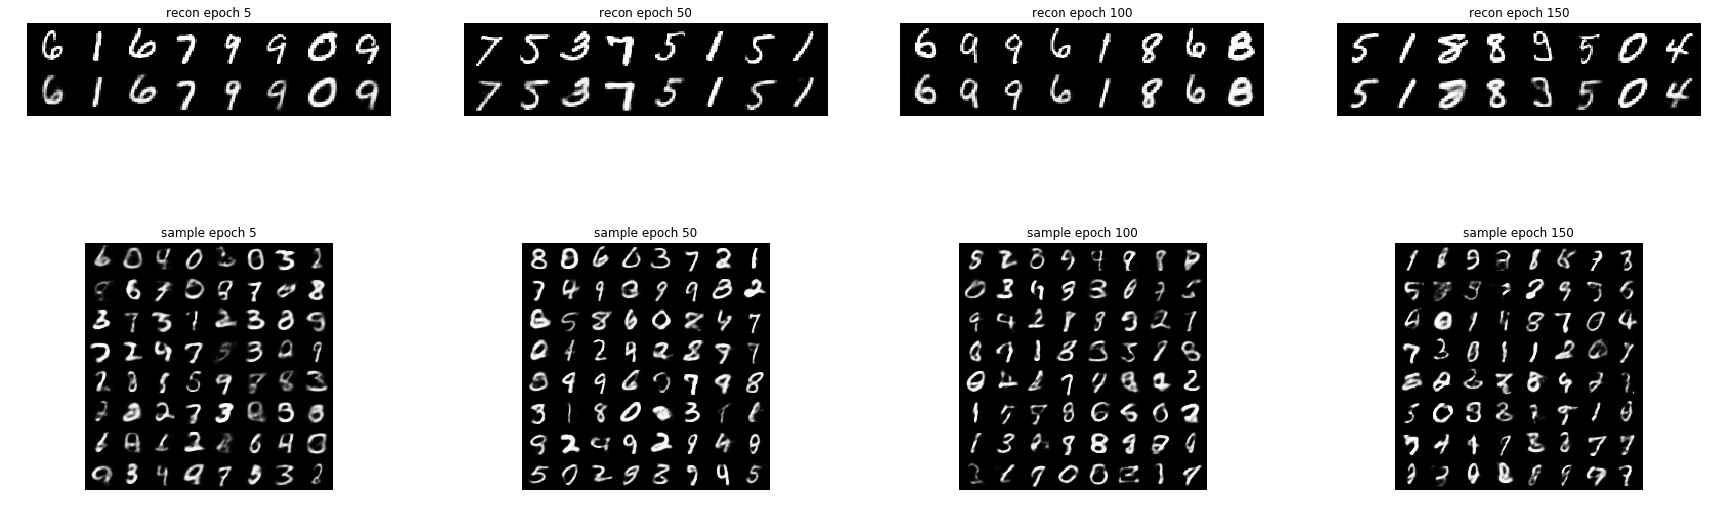

In [8]:
import cv2 
from matplotlib import pyplot as plt 
  
# create figure 
fig = plt.figure(figsize=(30,10)) 

rows = 2
columns = 4
  
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part1/reconstruction_5.png'))
plt.axis('off') 
plt.title("recon epoch 5") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part1/reconstruction_50.png'))
plt.axis('off') 
plt.title("recon epoch 50") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part1/reconstruction_100.png'))
plt.axis('off') 
plt.title("recon epoch 100") 
  
# showing image 
fig.add_subplot(rows, columns, 4) 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part1/reconstruction_150.png'))
plt.axis('off') 
plt.title("recon epoch 150") 

fig.add_subplot(rows, columns, 5) 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part1/sample_5.png'))
plt.axis('off') 
plt.title("sample epoch 5") 

fig.add_subplot(rows, columns, 6) 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part1/sample_50.png'))
plt.axis('off') 
plt.title("sample epoch 50") 

fig.add_subplot(rows, columns, 7) 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part1/sample_100.png'))
plt.axis('off') 
plt.title("sample epoch 100") 

fig.add_subplot(rows, columns, 8) 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part1/sample_150.png'))
plt.axis('off') 
plt.title("sample epoch 150") 

## Screenshot of visualized results on Visdom

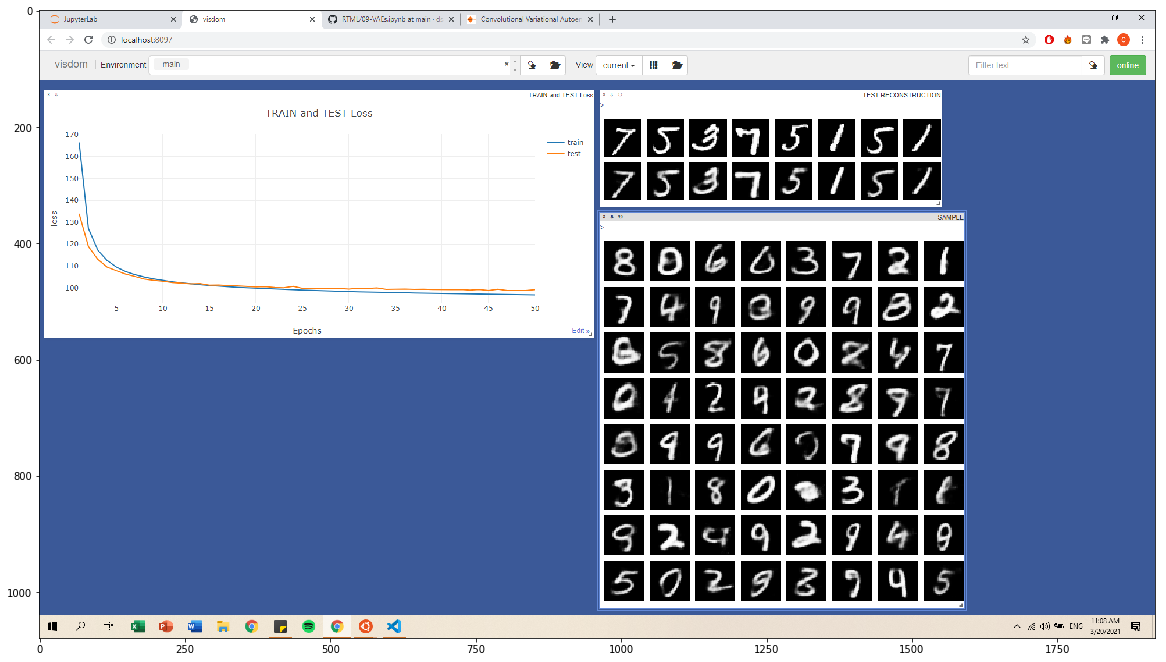

In [4]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread('mnistvisdom.png'))

# Part2 : VAE of AIT ICT Faces and a small subset of CelebA

In this part we tried using convolutional layers rather than fully connected layers for the encoder and decoder.

In [ ]:
# models.py
class newVAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(newVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

### main_part1.py

In [ ]:
# main_part2.py

log_interval = 100
seed = 1

torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset

compose = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.ToTensor(),
    ])

# load data
ds = torchvision.datasets.ImageFolder(root='ait', transform=compose)
# or
# ds = torchvision.datasets.ImageFolder(root='celeb', transform=compose)

train_dataset, test_dataset = torch.utils.data.random_split(ds, [300, 17]) # split data into train and test set

batch_size = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#%%

from models import newVAE, Flatten, UnFlatten

model = newVAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999), weight_decay = 0.0005)

#%%
from train_test import train,test

global plotter, test_recon_img, sample_recon_img
plotter = utils.VisdomLinePlotter(env_name='main')
test_recon_img = utils.VisdomImages(var_name='test_recon_img', env_name='main')
sample_recon_img = utils.VisdomImages(var_name='sample_recon_img', env_name='main')

epochs = 150
for epoch in range(1, epochs + 1):
    train(epoch, model, train_loader, device, optimizer, plotter)
    test(epoch, model, test_loader, device, optimizer, plotter, test_recon_img)

    # RECONSTRUCTED SAMPLE
    with torch.no_grad():
        sample = torch.randn(6, 32).to(device)
        sample = model.decode(sample).cpu()
        sample_recon_img.show_images(sample, 'SAMPLE')
        if epoch % 5 == 0:
            print("save image: " + 'results_part2/sample_' + str(epoch) + '.png')
            save_image(sample, 'results_part2/sample_' + str(epoch) + '.png')

## RESULTS of AIT and CELEB VAE

This is the script I used to train this model

    python3 main_part2.py -u > main_results_part2.txt
    
During training the train and test loss as well as the test reconstuction and sample images will be shown on visdom.

The output will be saved in a text file called main_results_part2.txt

and the test reconstruction and sample images will be saved to the /results_part2 folder every 5 epochs.

After trying many structure and training hyperparameters, the model in the newVAE class above is the one with the best results.

Here are the last 2 epochs of the main_results_part2.txt file.

        Train Epoch: 149 [0/300 (0%)]	Loss: 6441.581875
        ====> Epoch: 149 Average loss: 6369.6883
        ====> Test set loss: 6571.4991
        Train Epoch: 150 [0/300 (0%)]	Loss: 6361.725625
        ====> Epoch: 150 Average loss: 6344.0785
        ====> Test set loss: 6523.7711
        save image: results_part2/sample_150.png

We can also see from the plots in Visdom that the training and test loss of both the AIT and CELEB VAE are converging quite well even though there are some fluctuations which might be due to the small number of samples in the dataset


### AIT VAE
The resulting test reconstruction images are quite blurry but the model captured the silhouette of the profile images quite well so all the images has a clear shape of the head and the white background. However, the features on the face are not clear.

The sample images are also very blurry also with the silhouette of the head and hair.

### CELEB VAE

The test reconstruction images are more blurry than the AIT ones, with only silhouette of the face and neck with black and dark background. This might be because the faces in some images are not at the centered so it is harder for the model to learn.

The sample images are similar, very blurry with gray backgound.


Text(0.5,1,'CELEB sample epoch 175')

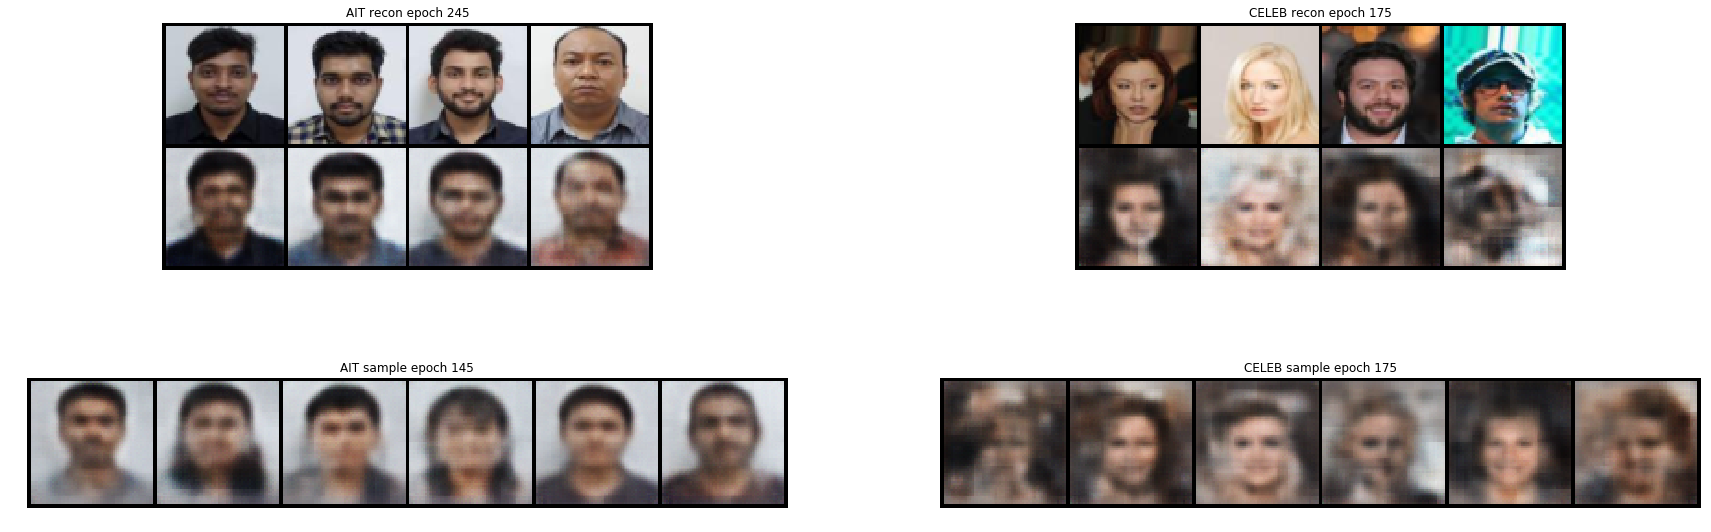

In [14]:
import cv2 
from matplotlib import pyplot as plt 
  
# create figure 
fig = plt.figure(figsize=(30,10)) 

rows = 2
columns = 2
  
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part2/reconstruction_245.png'))
plt.axis('off') 
plt.title("AIT recon epoch 245") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part2/reconstruction_175.png'))
plt.axis('off') 
plt.title("CELEB recon epoch 175") 

fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part2/sample_145.png'))
plt.axis('off') 
plt.title("AIT sample epoch 145") 
  
# showing image 
fig.add_subplot(rows, columns, 4) 
plt.imshow(mpimg.imread('../../RTML-gitlab/LAB9-VAE/results_part2/sample_175.png'))
plt.axis('off') 
plt.title("CELEB sample epoch 175") 


## Screenshot of visualized results on Visdom

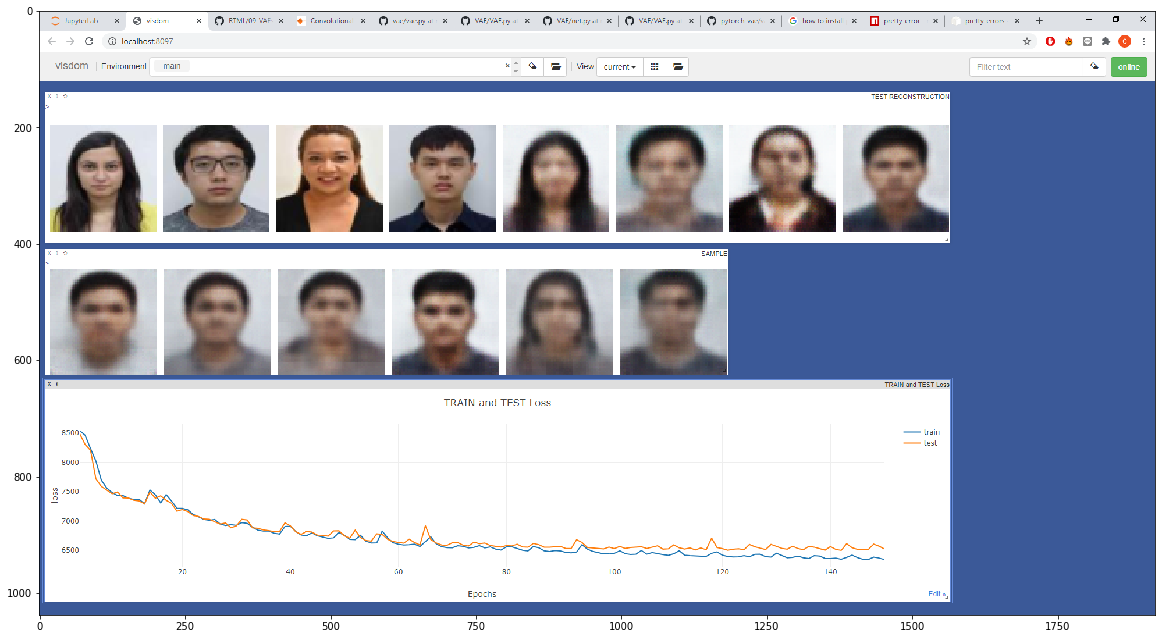

In [9]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread('aitvisdom.png'))

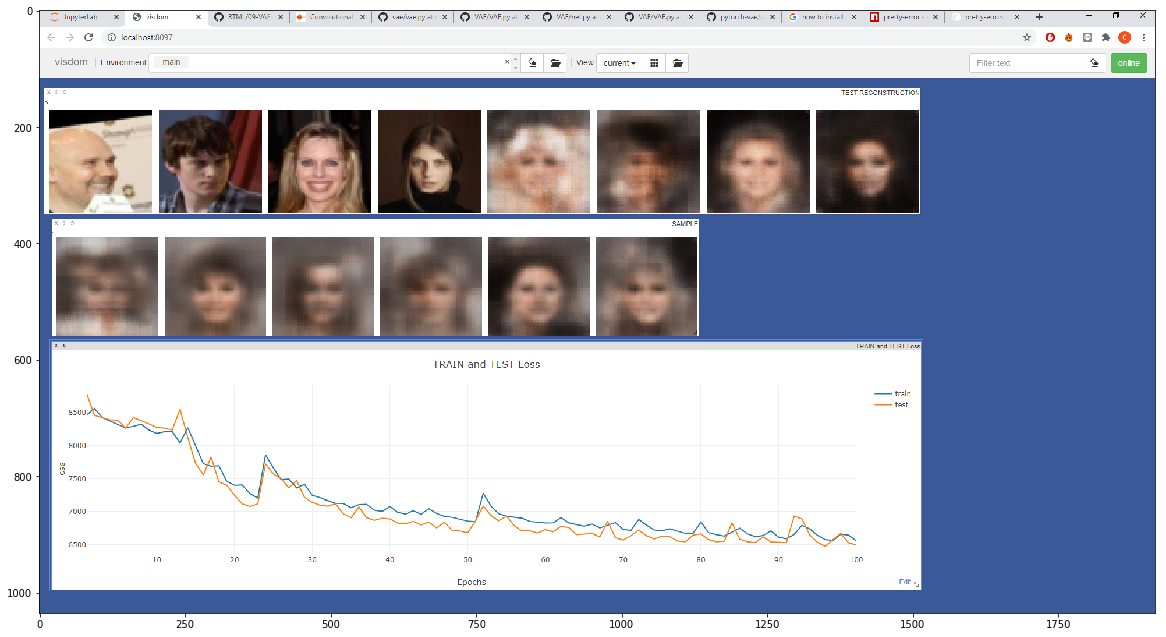

In [10]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(mpimg.imread('celebvisdom.png'))

# Conclusion & Discussion

In the first part of the lab we were able to generate new images of numbers from leaning the latent space of the MNIST dataset very beacutifully with a VAE which is composed of fully-connected layers for the encoder and decoder.

In the second part we attempted to train convolutional VAE on the AIT and CELEB dataset. The generated images are quite blurry. This imply that we might need a larger dataset for the VAE to learn and may also have to expand the size of the model even more.

I also learned how to set up visdom to visulize the results of training in real-time.